In [1]:
import pyspark
sc = pyspark.SparkContext()

In [2]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.functions import when
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer
from pyspark.ml.feature import Normalizer, MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.sql import Row, Column
from pyspark.sql.types import FloatType, DoubleType
import plotly.graph_objects as go
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.tree import DecisionTree as DT
from pyspark.mllib.tree import DecisionTreeModel, LabeledPoint

from pyspark.ml.clustering import KMeans
from pyspark.mllib.clustering import KMeans as KM

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.tree import LabeledPoint

from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import itertools


from pyspark.ml import Pipeline
from pyspark.sql.functions import udf

from pyspark.ml.feature import StringIndexer, VectorIndexer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
spark = SparkSession.builder \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
hdfs_path = 'hdfs://kddrtserver13.isti.cnr.it:9000/user/hpsa15/bank_dataset2.csv'

In [5]:
kdd_df = spark.read.options(inferSchema = True, header = True)\
                .csv(hdfs_path)  

In [ ]:
kdd_df = kdd_df.withColumn("y", when(kdd_df["y"] == "yes", 1.0).otherwise(0.0))

In [ ]:
kdd_df.count()

Divisione in training e test

In [7]:
train, test = kdd_df.randomSplit([0.7, 0.3], seed = 2)

Esecuzione del Decision Tree su tutto il dataset

In [8]:
feature_columns = ["age", "duration", "campaign", "pdays", "previous",
                   "emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m", "nr_employed"]

- 3Fold-CrossValidation

In [9]:
def exec_crossEvalTree(df):
    # Assemblaggio del clusters
    assembler = VectorAssembler().setInputCols(feature_columns).setOutputCol("features")
    tmp_df = assembler.transform(df)
    tmp_df =tmp_df.withColumnRenamed("y","label")
    # Training e test
    
    # Create initial Decision Tree Model
    model = DecisionTreeClassifier(labelCol="label", featuresCol="features")

    # Create ParamGrid for Cross Validation
    model_paramGrid = (ParamGridBuilder()
           .addGrid(model.impurity, ["entropy", "gini"])
           .addGrid(model.maxDepth, [2, 5, 10, 15])
           .addGrid(model.maxBins, [2, 5, 10, 15]).build())
    # Evaluate model
    model_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

    # Create 3-fold CrossValidator
    cross_model = CrossValidator(estimator = model,
                          estimatorParamMaps = model_paramGrid,
                          evaluator = model_evaluator,
                          numFolds = 3)

    # Run cross validations
    fit_model = cross_model.fit(tmp_df)
    print(fit_model)


    bestModel = fit_model.bestModel
    extract_par = bestModel.extractParamMap()
    best_parameters = {}
    best_parameters["impurity"] = extract_par[bestModel.getParam("impurity")]
    best_parameters["maxDepth"] = extract_par[bestModel.getParam("maxDepth")]
    best_parameters["maxBins"] = extract_par[bestModel.getParam("maxBins")]
    print(best_parameters)
    best_parameters
    
    return best_parameters

In [10]:
optimals = exec_crossEvalTree(train)

CrossValidatorModel_0aaaea51bca8
{'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 5}


### Valutazione del decision Tree eseguito su tutto il dataset (con i parametri ottimi)

- Trasformazione di Training e Test in labeled point

In [11]:
def toLabeld(df):
    return df.rdd.map(lambda row: LabeledPoint(row[20], [row[0:1] + row[10:14] + row[15:20]]))

In [12]:
train_labeled = toLabeld(train)

In [13]:
test_labeled = toLabeld(test)

- Funzione per plottare la confusion matrix

In [14]:
def plt_matrix(matrix, title):
    # Normalizzazione della matrice
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Aperto", "Non-Aperto"], rotation=45)
    plt.yticks(tick_marks, ["Aperto", "Non-Aperto"])

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid()
    plt.tight_layout()
    plt.plot()

- Funzione per stampare le metriche

In [15]:
def performance(df, title):
    metrics = MulticlassMetrics(df)
  
    print('  Accuracy '+str(metrics.accuracy))
    print('  F-1 Score         '+ str(metrics.fMeasure()))
    print('  Precision (False) '+ str(metrics.precision(0)))
    print('  Precision (True) '+str(metrics.precision(1)))
    print('  Recall (False)   '+str(metrics.recall(0)))
    print('  Recall (True)    '+str(metrics.recall(1)))
    print('  Confusion Matrix')
    matrix = metrics.confusionMatrix().toArray()
    print(matrix)
    plt_matrix(matrix, title)

- Funzione per stampare roc_auc

In [16]:
def roc_auc_plot(res, title):

    results_list = res.collect()
    y_score = [i[0] for i in results_list]
    y_test = [i[1] for i in results_list]
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    print("AUC MLlib: " + str(BinaryClassificationMetrics(res).areaUnderROC))
    %matplotlib inline
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.plot()

In [17]:
def get_labels_plot(model, data, title):    
    # 1 - Valore target predetto
    predictions = model.predict(data.map(lambda r: r.features))
    # 2 - Etichette per performance
    labels_ = predictions.zip(data.map(lambda r: r.label))
    # 3 - Stampa Performance
    performance(labels_, title)

- Esecuzione del Decision Tree

In [18]:
def exec_decisionTree(train, test, optimals):
    model = DT.trainClassifier(train, numClasses=2, 
                                         #categoricalFeaturesInfo = categoricalFeaturesInfo,
                                         categoricalFeaturesInfo = {},
                                        impurity = optimals["impurity"],
                                        maxDepth=optimals["maxDepth"],
                                        maxBins=optimals["maxBins"])

    print("<--------------- Metriche per Decision Tree ---------------->")
    print("          |  TRAINING  |")
    get_labels_plot(model, train, "Training cluster ")
    print("          |    TEST    |")
    get_labels_plot(model, test, "Test cluster ")
    tree = model.toDebugString()    
    for i in range(0,len(feature_columns)):
        tree=tree.replace("feature "+str(i)+" ", str(feature_columns[i])+" ")
    print(tree)


<--------------- Metriche per Decision Tree ---------------->
          |  TRAINING  |
  Accuracy 0.8578139680551206
  F-1 Score         0.8578139680551206
  Precision (False) 0.8904815884740557
  Precision (True) 0.21175637393767704
  Recall (False)   0.9596847290640395
  Recall (True)    0.08893515764425937
  Confusion Matrix
[[24378.  1129.]
 [ 2950.   280.]]
          |    TEST    |
  Accuracy 0.8554081222356252
  F-1 Score         0.8554081222356252
  Precision (False) 0.8943248532289628
  Precision (True) 0.21176470588235294
  Recall (False)   0.9545041772611697
  Recall (True)    0.08854532677442024
  Confusion Matrix
[[10550.   449.]
 [ 1276.   160.]]
DecisionTreeModel classifier of depth 5 with 25 nodes
  If (nr_employed <= 5087.65)
   If (duration <= 143.5)
    Predict: 0.0
   Else (duration > 143.5)
    If (pdays <= -0.5)
     If (duration <= 217.5)
      Predict: 0.0
     Else (duration > 217.5)
      If (duration <= 360.5)
       Predict: 0.0
      Else (duration > 360.5)


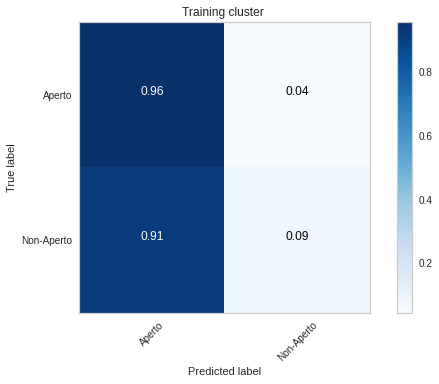

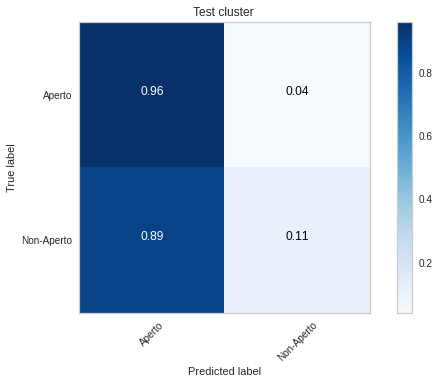

In [19]:
exec_decisionTree(train_labeled, test_labeled, optimals)

# Esecuzione del K-Means per ottenere i clusters (dal training)

- MinMaxScaler

In [20]:
features = ["age", "duration", "campaign","previous"]

In [21]:
scaledF = []
for i in features:
    scaledF.append(i+str("_Scaled"))
scaledF

['age_Scaled', 'duration_Scaled', 'campaign_Scaled', 'previous_Scaled']

In [22]:
numeric_df_withJ = train.filter(train["y"] == 1.0)

In [23]:
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

In [24]:
# Iterazione sulle colonne da normalizzare
for i in features:
    # VectorAssembler Transformation - Conversione da colonna a tipo vector
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    numeric_df_withJ = pipeline.fit(numeric_df_withJ).transform(numeric_df_withJ).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

In [25]:
numeric_df_withJ = numeric_df_withJ.withColumnRenamed("features","tt_features")
assembler = VectorAssembler().setInputCols(scaledF).setOutputCol("features")
transformed = assembler.transform(numeric_df_withJ)

In [26]:
transformed.show()

+---+-----------+-------+-------------------+-------+-------+-------+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+----------+---------------+---------------+---------------+--------------------+
|age|        job|marital|          education|default|housing|   loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|age_Scaled|duration_Scaled|campaign_Scaled|previous_Scaled|            features|
+---+-----------+-------+-------------------+-------+-------+-------+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+----------+---------------+---------------+---------------+--------------------+
| 17|    student| single|           basic.9y|     no|unknown|unknown| cellular|  aug|        fri|     498|       2|   -1|      

- Scelta k: wsse

In [86]:
wssse = {}
centers = {}
for k in range(2, 20):
    kmeans = KMeans(k=k, seed=1).fit(transformed.select("features"))
    wssse[k] = kmeans.computeCost(transformed.select("features"))
    centers[k] = kmeans.clusterCenters()

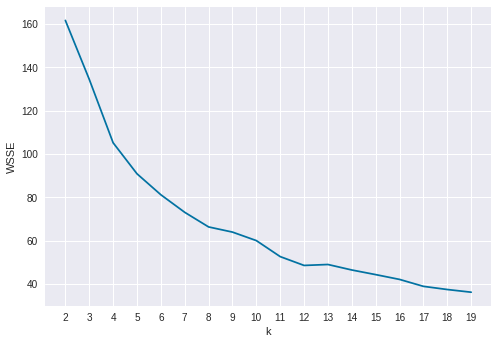

7


In [87]:
plt.figure()
plt.style.use('seaborn-darkgrid')
plt.xticks(range(2,20, 1))
plt.plot(list(wssse.keys()), list(wssse.values()))
plt.xlabel("k")
plt.ylabel("WSSE")
plt.show()

kl = KneeLocator(
    range(2, 20), list(wssse.values()), curve="convex", direction="decreasing"
)

print(kl.elbow)

In [88]:
for i in range(2, 20):
    print("k = " + str(i) + "| WSSSE = " + str(wssse[i]))

k = 2| WSSSE = 161.5379234203003
k = 3| WSSSE = 134.3948603868511
k = 4| WSSSE = 105.12649264210155
k = 5| WSSSE = 90.82889923839524
k = 6| WSSSE = 81.15028099435038
k = 7| WSSSE = 73.05986161493745
k = 8| WSSSE = 66.3194678042402
k = 9| WSSSE = 63.938473530954305
k = 10| WSSSE = 60.020480140238504
k = 11| WSSSE = 52.63451739431245
k = 12| WSSSE = 48.564767471898946
k = 13| WSSSE = 48.998465811292554
k = 14| WSSSE = 46.46338977859313
k = 15| WSSSE = 44.33313682559101
k = 16| WSSSE = 42.12032617003526
k = 17| WSSSE = 38.922506660449805
k = 18| WSSSE = 37.46395972082035
k = 19| WSSSE = 36.222259356814845


In [89]:
for i in range(3, 15):
    kmeans = KMeans(k=i, seed=1)
    model = kmeans.fit(transformed)
    predictions = model.transform(transformed)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance  of", i," = " + str(silhouette))

Silhouette with squared euclidean distance  of 3  = 0.354339828643153
Silhouette with squared euclidean distance  of 4  = 0.3995050415583894
Silhouette with squared euclidean distance  of 5  = 0.4039326125333354
Silhouette with squared euclidean distance  of 6  = 0.3776633171232702
Silhouette with squared euclidean distance  of 7  = 0.38991737392380893
Silhouette with squared euclidean distance  of 8  = 0.40700050152788847
Silhouette with squared euclidean distance  of 9  = 0.377693402860088
Silhouette with squared euclidean distance  of 10  = 0.3850903232424558
Silhouette with squared euclidean distance  of 11  = 0.40823165357396085
Silhouette with squared euclidean distance  of 12  = 0.41855593384874085
Silhouette with squared euclidean distance  of 13  = 0.420916331240361
Silhouette with squared euclidean distance  of 14  = 0.3837769535335197


- Eseguiamo il clustering con k = 7

In [27]:
kmeans = KMeans(k=8, seed=1)
model = kmeans.fit(transformed.select("features"))

In [28]:
predictions = model.transform(transformed)

In [29]:
def basic_statistics(df):
    for i in df.dtypes:
        if(i[1] == 'int' or i[1] == 'double'):
            df.describe(i[0]).show(truncate=False)

In [30]:
features_tosel = ["age", "job", "marital", "education", "default", 
                  "housing", "loan", "contact", "month", "day_of_week", 
                  "duration", "campaign", "pdays", "previous", "poutcome",
                  "emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m",
                  "nr_employed"]

In [31]:
features_numeric = ["age", "duration", "campaign", "pdays", "previous",
                  "emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m",
                  "nr_employed"]

In [32]:
features_notnumeric = ["job", "marital", "education", "default", 
                  "housing", "loan", "contact", "month", "day_of_week"]

In [33]:
dist_clusters = predictions.select("prediction").distinct().rdd.map(lambda x: x[0]).collect()
dd = {}
for i in dist_clusters:
    dd[i] = predictions.filter(predictions["prediction"] == i).select(features_tosel)

In [34]:
dd

{1: DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double],
 6: DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double],
 3: DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_

In [98]:
for i in dist_clusters:
    print("----------- Statistiche cluster n°: " + str(i) + " --------")
    basic_statistics(dd[i].select(features_numeric))

----------- Statistiche cluster n°: 1 --------
+-------+-----------------+
|summary|age              |
+-------+-----------------+
|count  |293              |
|mean   |70.72013651877133|
|stddev |8.407647202883103|
|min    |58               |
|max    |92               |
+-------+-----------------+

+-------+------------------+
|summary|duration          |
+-------+------------------+
|count  |293               |
|mean   |334.51194539249144|
|stddev |227.10127793346012|
|min    |63                |
|max    |1962              |
+-------+------------------+

+-------+------------------+
|summary|campaign          |
+-------+------------------+
|count  |293               |
|mean   |1.8361774744027304|
|stddev |1.3320811284522167|
|min    |1                 |
|max    |11                |
+-------+------------------+

+-------+------------------+
|summary|pdays             |
+-------+------------------+
|count  |293               |
|mean   |1.9044368600682593|
|stddev |4.186297049491577 |
|m

+-------+------------------+
|summary|duration          |
+-------+------------------+
|count  |542               |
|mean   |372.6826568265683 |
|stddev |220.22671655754974|
|min    |71                |
|max    |1370              |
+-------+------------------+

+-------+------------------+
|summary|campaign          |
+-------+------------------+
|count  |542               |
|mean   |1.6918819188191883|
|stddev |1.0078658116778203|
|min    |1                 |
|max    |7                 |
+-------+------------------+

+-------+-----------------+
|summary|pdays            |
+-------+-----------------+
|count  |542              |
|mean   |3.503690036900369|
|stddev |4.731905436202723|
|min    |-1               |
|max    |27               |
+-------+-----------------+

+-------+------------------+
|summary|previous          |
+-------+------------------+
|count  |542               |
|mean   |1.2527675276752768|
|stddev |0.4350002628347881|
|min    |1                 |
|max    |2          

+-------+--------------------+
|summary|pdays               |
+-------+--------------------+
|count  |661                 |
|mean   |-0.34190620272314676|
|stddev |2.2417286343303506  |
|min    |-1                  |
|max    |16                  |
+-------+--------------------+

+-------+-------------------+
|summary|previous           |
+-------+-------------------+
|count  |661                |
|mean   |0.2042360060514372 |
|stddev |0.40344752800471473|
|min    |0                  |
|max    |1                  |
+-------+-------------------+

+-------+-------------------+
|summary|emp_var_rate       |
+-------+-------------------+
|count  |661                |
|mean   |-1.1261724659606653|
|stddev |1.72530946558251   |
|min    |-3.4               |
|max    |1.4                |
+-------+-------------------+

+-------+------------------+
|summary|cons_price_idx    |
+-------+------------------+
|count  |661               |
|mean   |93.28712254160362 |
|stddev |0.6469150301028166|
|min

In [99]:
for i in dist_clusters:
    print("----------- Info categorici cluster n°: " + str(i) + " --------")
    for j in features_notnumeric:
        dd[i].createOrReplaceTempView("tmp")
        tot_j = dd[i].select(j).count()
        query = spark.sql("SELECT "+str(j)+", count(*)/"+str(tot_j)+" * 100 FROM tmp GROUP BY "+ str(j))
        print("<<-- feature:"+ str(j))
        query.show()

----------- Info categorici cluster n°: 1 --------
<<-- feature:job
+-------------+------------------------------------------------------------------------+
|          job|((CAST(count(1) AS DOUBLE) / CAST(293 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+-------------+------------------------------------------------------------------------+
|   management|                                                       4.778156996587031|
|      retired|                                                       73.37883959044369|
|      unknown|                                                      1.3651877133105803|
|self-employed|                                                      0.3412969283276451|
|  blue-collar|                                                      1.3651877133105803|
| entrepreneur|                                                       1.023890784982935|
|       admin.|                                                       7.508532423208192|
|   technician|                           

<<-- feature:marital
+--------+------------------------------------------------------------------------+
| marital|((CAST(count(1) AS DOUBLE) / CAST(177 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+--------+------------------------------------------------------------------------+
|divorced|                                                      12.429378531073446|
| married|                                                      61.016949152542374|
|  single|                                                       26.55367231638418|
+--------+------------------------------------------------------------------------+

<<-- feature:education
+-------------------+------------------------------------------------------------------------+
|          education|((CAST(count(1) AS DOUBLE) / CAST(177 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+-------------------+------------------------------------------------------------------------+
|        high.school|                                                       18.079

<<-- feature:default
+-------+------------------------------------------------------------------------+
|default|((CAST(count(1) AS DOUBLE) / CAST(235 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+-------+------------------------------------------------------------------------+
|unknown|                                                       21.27659574468085|
|     no|                                                       78.72340425531915|
+-------+------------------------------------------------------------------------+

<<-- feature:housing
+-------+------------------------------------------------------------------------+
|housing|((CAST(count(1) AS DOUBLE) / CAST(235 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+-------+------------------------------------------------------------------------+
|unknown|                                                       2.127659574468085|
|     no|                                                      46.808510638297875|
|    yes|                                   

<<-- feature:loan
+-------+------------------------------------------------------------------------+
|   loan|((CAST(count(1) AS DOUBLE) / CAST(542 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+-------+------------------------------------------------------------------------+
|unknown|                                                      2.7675276752767526|
|     no|                                                       84.13284132841329|
|    yes|                                                      13.099630996309964|
+-------+------------------------------------------------------------------------+

<<-- feature:contact
+---------+------------------------------------------------------------------------+
|  contact|((CAST(count(1) AS DOUBLE) / CAST(542 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+---------+------------------------------------------------------------------------+
| cellular|                                                       92.43542435424355|
|telephone|                            

<<-- feature:month
+-----+------------------------------------------------------------------------+
|month|((CAST(count(1) AS DOUBLE) / CAST(804 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+-----+------------------------------------------------------------------------+
|  jun|                                                       15.17412935323383|
|  aug|                                                       9.950248756218906|
|  may|                                                      15.298507462686567|
|  sep|                                                       4.975124378109453|
|  mar|                                                      10.074626865671641|
|  oct|                                                        8.45771144278607|
|  jul|                                                      10.199004975124378|
|  nov|                                                       7.835820895522389|
|  apr|                                                       17.16417910447761|
|  dec|  

<<-- feature:day_of_week
+-----------+------------------------------------------------------------------------+
|day_of_week|((CAST(count(1) AS DOUBLE) / CAST(567 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+-----------+------------------------------------------------------------------------+
|        fri|                                                      18.871252204585538|
|        thu|                                                       22.22222222222222|
|        tue|                                                      17.636684303350968|
|        wed|                                                       22.39858906525573|
|        mon|                                                      18.871252204585538|
+-----------+------------------------------------------------------------------------+

----------- Info categorici cluster n°: 0 --------
<<-- feature:job
+-------------+------------------------------------------------------------------------+
|          job|((CAST(count(1) AS 

In [ ]:
clusters = predictions.select("prediction").collect()
age = predictions.select("age").collect()
duration = predictions.select("duration").collect()
campaign= predictions.select("campaign").collect()
previous=predictions.select("previous").collect()
fig = go.Figure(data=
                go.Parcoords(
                    dimensions = list([
                        dict(
                            label = "Age", values = age),
                        dict(
                            label = "Duration", values = duration),
                        dict(
                            label = "Campaign", values = campaign),
                        dict(
                            label = "Previous", values = previous),
                        dict(
                            label = 'Clusters', values = clusters)
                    ])
                )
        )
fig.show()

## Aggiunta dei record con target='no' ai clusters

In [35]:
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# Iterazione sulle colonne da normalizzare
for i in features:
    # VectorAssembler Transformation - Conversione da colonna a tipo vector
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    train = pipeline.fit(train).transform(train).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

all_df = train.withColumnRenamed("features","tt_features")
assembler = VectorAssembler().setInputCols(scaledF).setOutputCol("features")
all_df = assembler.transform(all_df)

In [36]:
train.count()

28737

In [37]:
all_df

DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: double, age_Scaled: double, duration_Scaled: double, campaign_Scaled: double, previous_Scaled: double, features: vector]

In [38]:
predictions = model.transform(all_df)

- Conteggio elementi per ogni cluster

In [104]:
predictions.createOrReplaceTempView("tmp")

In [105]:
query = spark.sql("SELECT prediction, count(*) FROM tmp GROUP BY prediction")
query.show()

+----------+--------+
|prediction|count(1)|
+----------+--------+
|         1|     547|
|         6|     207|
|         3|     351|
|         5|    2534|
|         4|   14624|
|         2|    1370|
|         0|    9104|
+----------+--------+



In [39]:
predictions

DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: double, age_Scaled: double, duration_Scaled: double, campaign_Scaled: double, previous_Scaled: double, features: vector, prediction: int]

In [40]:
predictions = predictions.drop("age_Scaled", "duration_Scaled", "campaign_Scaled", "previous_Scaled")

In [41]:
predictions

DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: double, features: vector, prediction: int]

- Selezione Clusters: un dizionario della forma <cluster[i], dataframe[i]>

In [42]:
prediction_v = predictions.select("prediction").distinct().rdd.map(lambda r: r[0]).collect()
prediction_v

[1, 6, 3, 5, 4, 2, 0]

In [43]:
def list_clusters(df, prediction):
    ll= {}
    for i in prediction:
        ll[i] = df.filter(df["prediction"]==i).select(df.columns[:-1])
    return ll

In [45]:
dataset_prima_della_divisione = predictions

In [44]:
clusters_df = list_clusters(predictions, prediction_v)
clusters_df

{1: DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: double, features: vector],
 6: DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: double, features: vector],
 3: DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous

# Esecuzione del decision tree per ogni clusters dove:
- clusters_df[i] è il training
- test viene prima trasformato per avere le etichette di clusters e poi per ogni etichetta usare quell'insieme come test per il decision tree del cluster corrispondente

- Sistemare il test per poter eseguire il clustering

In [46]:
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# Iterazione sulle colonne da normalizzare
for i in features:
    # VectorAssembler Transformation - Conversione da colonna a tipo vector
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    test = pipeline.fit(test).transform(test).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

test_df = test.withColumnRenamed("features","tt_features")
assembler = VectorAssembler().setInputCols(scaledF).setOutputCol("features")
test_df = assembler.transform(test_df)

In [47]:
test_df

DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: double, age_Scaled: double, duration_Scaled: double, campaign_Scaled: double, previous_Scaled: double, features: vector]

- Aggiunta delle predizioni al test

In [48]:
predictions = model.transform(test_df)

- Conteggio elementi del test per ogni cluster

In [122]:
predictions.createOrReplaceTempView("tmp")

In [123]:
query = spark.sql("SELECT prediction, count(*) FROM tmp GROUP BY prediction")
query.show()

+----------+--------+
|prediction|count(1)|
+----------+--------+
|         1|     216|
|         6|     155|
|         3|      58|
|         5|    1115|
|         4|    6991|
|         2|     352|
|         0|    3548|
+----------+--------+



- Creo i test per i clusters: 
- selezione Clusters: un dizionario della forma <cluster[i], dataframe[i]>

In [49]:
predictions = predictions.drop("age_Scaled", "duration_Scaled", "campaign_Scaled", "previous_Scaled")

In [50]:
predictions

DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: double, features: vector, prediction: int]

In [51]:
prediction_v = predictions.select("prediction").distinct().rdd.map(lambda r: r[0]).collect()
prediction_v

[1, 6, 3, 5, 4, 2, 0]

In [52]:
def list_clusters(df, prediction):
    ll= {}
    for i in prediction:
        ll[i] = df.filter(df["prediction"]==i).select(df.columns[:-1])
    return ll

clusters_test_df = list_clusters(predictions, prediction_v)
clusters_test_df

{1: DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: double, features: vector],
 6: DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: double, features: vector],
 3: DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous

# Scelta degli iperparametri per il decision Tree di ogni cluster in clusters_df

In [53]:
features_numeric = ["age", "duration", "campaign", "pdays", "previous",
                  "emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m",
                  "nr_employed"]

- 3Fold-CrossValidation

In [129]:
def exec_crossEvalTree(df, prediction_v):
    optimals = {}
    for i in prediction_v:
        # Assemblaggio del clusters
        assembler = VectorAssembler().setInputCols(features_numeric).setOutputCol("features")
        tmp_df = assembler.transform(df[i])
        train =tmp_df.withColumnRenamed("y","label")
        # Training e test
        
        # Create initial Decision Tree Model
        model = DecisionTreeClassifier(labelCol="label", featuresCol="features")
        
        # Create ParamGrid for Cross Validation
        model_paramGrid = (ParamGridBuilder()
               .addGrid(model.impurity, ["entropy", "gini"])
               .addGrid(model.maxDepth, [2, 5, 10, 15])
               .addGrid(model.maxBins, [2, 5, 10, 15]).build())
        # Evaluate model
        model_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

        # Create 3-fold CrossValidator
        cross_model = CrossValidator(estimator = model,
                              estimatorParamMaps = model_paramGrid,
                              evaluator = model_evaluator,
                              numFolds = 3)

        # Run cross validations
        fit_model = cross_model.fit(train)
        print(fit_model)

        
        bestModel = fit_model.bestModel
        extract_par = bestModel.extractParamMap()
        best_parameters = {}
        best_parameters["impurity"] = extract_par[bestModel.getParam("impurity")]
        best_parameters["maxDepth"] = extract_par[bestModel.getParam("maxDepth")]
        best_parameters["maxBins"] = extract_par[bestModel.getParam("maxBins")]
        print(best_parameters)
        optimals[i] = best_parameters
        print(optimals)
    return optimals

In [54]:
for i in prediction_v:
    clusters_df[i] =  clusters_df[i].drop("features")

In [55]:
clusters_df

{1: DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: double],
 6: DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: double],
 3: DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rat

In [135]:
optimals = exec_crossEvalTree(clusters_df, prediction_v)

CrossValidatorModel_b22dbde71d62
{'impurity': 'entropy', 'maxDepth': 15, 'maxBins': 10}
{1: {'impurity': 'entropy', 'maxDepth': 15, 'maxBins': 10}}
CrossValidatorModel_7478737b6512
{'impurity': 'entropy', 'maxDepth': 2, 'maxBins': 15}
{1: {'impurity': 'entropy', 'maxDepth': 15, 'maxBins': 10}, 6: {'impurity': 'entropy', 'maxDepth': 2, 'maxBins': 15}}
CrossValidatorModel_3fa9b5551fa8
{'impurity': 'gini', 'maxDepth': 15, 'maxBins': 15}
{1: {'impurity': 'entropy', 'maxDepth': 15, 'maxBins': 10}, 6: {'impurity': 'entropy', 'maxDepth': 2, 'maxBins': 15}, 3: {'impurity': 'gini', 'maxDepth': 15, 'maxBins': 15}}
CrossValidatorModel_56f2e20a73b8
{'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 5}
{1: {'impurity': 'entropy', 'maxDepth': 15, 'maxBins': 10}, 6: {'impurity': 'entropy', 'maxDepth': 2, 'maxBins': 15}, 3: {'impurity': 'gini', 'maxDepth': 15, 'maxBins': 15}, 5: {'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 5}}
CrossValidatorModel_093bc3d8a927
{'impurity': 'entropy', 'maxDepth': 5,

In [136]:
optimals

{1: {'impurity': 'entropy', 'maxDepth': 15, 'maxBins': 10},
 6: {'impurity': 'entropy', 'maxDepth': 2, 'maxBins': 15},
 3: {'impurity': 'gini', 'maxDepth': 15, 'maxBins': 15},
 5: {'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 5},
 4: {'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 15},
 2: {'impurity': 'entropy', 'maxDepth': 10, 'maxBins': 15},
 0: {'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 5}}

- Trasformiamo trainin e test in labeled point

In [146]:
clusters_df[0]

DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: double]

In [57]:
def splitted_trainTest(prediction_v, clusters_df, clusters_test_df):
    splitted_clusters = {}
    for i in prediction_v:
        tr_i = clusters_df[i].rdd.map(lambda row: LabeledPoint(row[20], [row[0:1] + row[10:14] + row[15:20]]))
        ts_i = clusters_test_df[i].rdd.map(lambda row: LabeledPoint(row[20], [row[0:1] + row[10:14] + row[15:20]]))
        splitted_clusters[i] =[tr_i, ts_i] 
    return splitted_clusters

In [58]:
splitted_clusters = splitted_trainTest(prediction_v, clusters_df, clusters_test_df)

In [59]:
splitted_clusters

{1: [PythonRDD[7932] at RDD at PythonRDD.scala:53,
  PythonRDD[7933] at RDD at PythonRDD.scala:53],
 6: [PythonRDD[7934] at RDD at PythonRDD.scala:53,
  PythonRDD[7935] at RDD at PythonRDD.scala:53],
 3: [PythonRDD[7936] at RDD at PythonRDD.scala:53,
  PythonRDD[7937] at RDD at PythonRDD.scala:53],
 5: [PythonRDD[7938] at RDD at PythonRDD.scala:53,
  PythonRDD[7939] at RDD at PythonRDD.scala:53],
 4: [PythonRDD[7940] at RDD at PythonRDD.scala:53,
  PythonRDD[7941] at RDD at PythonRDD.scala:53],
 2: [PythonRDD[7942] at RDD at PythonRDD.scala:53,
  PythonRDD[7943] at RDD at PythonRDD.scala:53],
 0: [PythonRDD[7944] at RDD at PythonRDD.scala:53,
  PythonRDD[7945] at RDD at PythonRDD.scala:53]}

In [76]:
def exec_clustersDT(df, prediction_v, optimals):
    ll = []
    for i in prediction_v:
        cc = optimals[i]
        train, test = df[i]
        
        # ---- 
        #       Parte per risolvere i problemi con la zip
        c1 = train.coalesce(1, False)
        c2 = test.coalesce(1, False)

        c1_list = np.array(c1.collect())
        c2_list = np.array(c2.collect())

        train = sc.parallelize(c1_list, 15)
        test = sc.parallelize(c2_list, 15)
        
        # ----
        model = DT.trainClassifier(train, numClasses=2, 
                                             categoricalFeaturesInfo = {},
                                            impurity = cc["impurity"],
                                            maxDepth=cc["maxDepth"],
                                            maxBins=cc["maxBins"])
        predictions = model.predict(test.map(lambda r: r.features))
        # 2 - Etichette per performance
        labels_ = predictions.zip(test.map(lambda r: r.label))
        
        ll.append(labels_)
        print("Eseguito clusters " + str(i))
    return ll

In [77]:
ll = exec_clustersDT(splitted_clusters, prediction_v, optimals)

Eseguito clusters 1
Eseguito clusters 6
Eseguito clusters 3
Eseguito clusters 5
Eseguito clusters 4
Eseguito clusters 2
Eseguito clusters 0


- Unione di tutti gli rdd di labels per verificare i risultati

In [80]:
ss = []
for i in ll:
    ss = ss + i.collect()

In [84]:
res_tst =sc.parallelize(ss)

  Accuracy 0.908886208283072
  F-1 Score         0.908886208283072
  Precision (False) 0.9312857886517438
  Precision (True) 0.6248624862486248
  Recall (False)   0.9692099322799097
  Recall (True)    0.4176470588235294
  Confusion Matrix
[[10734.   341.]
 [  792.   568.]]


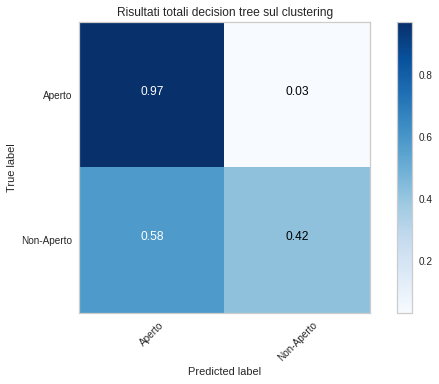

In [89]:
performance(res_tst, "Risultati totali decision tree sul clustering")